# Reference code: JAK2 activity optimization with ReLeaSE algorithm

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import numpy as np
import pandas as pd
import selfies as sf
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [5]:
from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData, normalize_SMILES

## Setting up the generator

### Loading data for the generator

In [6]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'zinc15')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_1_pretraining_ReBADD', 'zinc15')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [7]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 600116
Number of vocabulary: 49
Maximum of seqlen: 156


## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

Initialize stack-augmented generative RNN:

In [8]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 156,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 0.001,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [9]:
my_generator = StackAugmentedVAE(**kwargs_generator)

If you want train the model from scratch, uncomment the lines below:

In [10]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.txt')

In [11]:
losses = my_generator.fit(gen_data, n_iterations=15000,
                          batch_size=32,
                          print_every=1000,
                          ckpt_every=1000,
                          model_path=model_path,
                          losses_path=losses_path)

Training in progress...:   7%|▋         | 999/15000 [1:48:00<25:22:23,  6.52s/it]

[01000 (6.7%) 108m 7s], Loss_vae:1.159, Loss_rec:1.141, Loss_kld:1.773, Beta:0.067


Training in progress...:   7%|▋         | 1000/15000 [1:48:07<25:41:29,  6.61s/it]

selfies: [C][C][=C][C][=C][Branch2][Ring2][=C][S][=Branch1][C][=O][=Branch1][C][=O][N][Branch2][Ring2][Branch2][C][C][=Branch1][C][=O][C][=C][C][=C][Branch2][Ring1][=Branch1][C][N][C][C][C][N][Branch2][Ring1][Ring2][C][C][=C][Branch1][C][Cl][C][=C][C][=C][Ring1][#Branch1][Cl][C][=Branch1][C][=O][C][N][Branch1][=C][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][Branch2][C][=Branch1][C][=O][C][N][Branch1][N][C][=C][O][C][Branch1][C][Br][=C][Ring1][#Branch1][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][C][N][Branch1][=N][C][=C][C][=C][C][Branch1][C][Cl][=C][Ring1][#Branch1][C][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][Branch1][C][C][=C][C][Branch1][C][Cl][=C][Ring1][Branch2][C][=Branch1][C][=O][C][Ring2][Ring1][O][=O]
smiles: CC=CC=C(S(=O)(=O)NCC(=O)C=CC=CCNCCCNCC1=C(Cl)C=CC=C1Cl)CC2=CC=C(OC)C=C2C(=O)CN(C=COC(Br)=CS)C=O


Training in progress...:  13%|█▎        | 2000/15000 [3:36:32<23:44:06,  6.57s/it]

[02000 (13.3%) 216m 32s], Loss_vae:0.811, Loss_rec:0.785, Loss_kld:0.267, Beta:0.133
selfies: [C][O][C][=Branch1][C][=O][C][=C][C][=C][Branch2][Ring2][S][C][=Branch1][C][=O][N][C][=C][C][=C][Branch2][Ring1][Branch2][N][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][Branch1][C][Cl][C][=C][Branch1][C][Cl][C][=C][Ring1][Branch2][Cl][C][Ring2][Ring1][C][C][=C][Ring2][Ring1][N][C][Branch1][C][C][S][Ring2][Ring1][=N][O][Ring2][Ring2][Branch2]
smiles: C1OC(=O)C=C2C=C(C(=O)NC3=CC=C(NS(=O)(=O)C4=C(Cl)C=C(Cl)C=C4Cl)C3C=CCC)S2O1


Training in progress...:  20%|██        | 3000/15000 [5:26:54<22:02:15,  6.61s/it]

[03000 (20.0%) 326m 54s], Loss_vae:0.731, Loss_rec:0.697, Loss_kld:0.202, Beta:0.200
selfies: [C][C][C][C][N][C][Branch2][Ring1][Ring2][C][=C][C][=C][C][=C][Branch1][C][C][C][Branch1][C][Cl][=C][Ring1][Branch2][O][Ring1][=N][C][C][Ring2][Ring1][Branch2][C][Ring2][Ring1][N][=O][N][C][=C][C][=C][Branch1][C][C][C][=C][Ring1][#Branch1][F]
smiles: C12CCCN3C(C=CC4=CC=C(C)C(Cl)=C4O3)CC1C2=O


Training in progress...:  27%|██▋       | 4000/15000 [7:14:22<19:47:20,  6.48s/it]

[04000 (26.7%) 434m 22s], Loss_vae:0.697, Loss_rec:0.652, Loss_kld:0.193, Beta:0.267
selfies: [C][C][=C][Branch1][C][C][C][C][=C][C][Branch2][Branch1][Ring1][N][C][=Branch1][C][=O][C][=Branch2][Ring2][=Branch1][=C][C][=C][C][=C][Branch2][Ring1][C][O][C][C][=C][C][=C][Branch1][C][Cl][C][Branch1][C][Cl][=C][Ring1][Branch2][C][Ring1][=C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][Ring2][Ring1][Branch2][=C][Ring2][Ring2][N]
smiles: C1C=C(C2)C3C=CC1NC(=O)C3=CC=CC=C2OCC4=CC=C(Cl)C(Cl)=C4C


Training in progress...:  33%|███▎      | 5000/15000 [9:00:05<17:46:59,  6.40s/it]

[05000 (33.3%) 540m 5s], Loss_vae:0.676, Loss_rec:0.621, Loss_kld:0.183, Beta:0.333
selfies: [O][=C][Branch2][Ring2][#C][C][O][C][=Branch1][C][=O][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][N][=C][Branch2][Ring1][Ring1][S][C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][N][=C][Ring1][=N][C][=C][Ring2][Ring1][#Branch1][O][C]
smiles: O=C(COC(=O)C1=C2C=CC(=C1)N=C(SC3C(=O)NC4=CC=C(F)C=C4)N=C3C=C2)OC


Training in progress...:  40%|████      | 6000/15000 [10:50:00<17:39:35,  7.06s/it]

[06000 (40.0%) 650m 0s], Loss_vae:0.662, Loss_rec:0.598, Loss_kld:0.176, Beta:0.400
selfies: [C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C][Branch1][=N][C][=C][C][=C][C][Branch1][C][Cl][=C][Ring1][#Branch1][O][C][=N][N][=C][Ring2][Ring1][C][C][Ring2][Ring1][O][C][=C][Ring2][Ring1][P][O][C]
smiles: COC1=CC=C2C=C1NC(=O)C(CC3=CC=CC4=C3)NC(=O)C(C5=CC=CC(Cl)=C5O)C=NN=C4CC=C2OC


Training in progress...:  47%|████▋     | 7000/15000 [12:50:54<15:34:59,  7.01s/it]

[07000 (46.7%) 770m 54s], Loss_vae:0.653, Loss_rec:0.581, Loss_kld:0.168, Beta:0.467
selfies: [O][=C][N][C][=Branch1][C][=O][N][Branch1][N][C][=C][C][=C][C][Branch1][C][Br][=C][Ring1][#Branch1][C][Branch1][#Branch2][C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring2][Ring1][Branch1][=C][Ring2][Ring1][N][O][C]
smiles: O=CNC(=O)N(C1=CC=CC(Br)=C1)C(COC2=CC=CC=C2)C=CCOC


Training in progress...:  53%|█████▎    | 8000/15000 [14:50:39<13:24:52,  6.90s/it]

[08000 (53.3%) 890m 39s], Loss_vae:0.647, Loss_rec:0.563, Loss_kld:0.167, Beta:0.533
selfies: [C][C][=Branch1][C][=O][N][C][C][C][C][C][N][Branch1][S][C][=Branch1][C][=O][C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Branch1][#C][C][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1][F][N][C][=Branch1][C][=O][C][C][C][Ring2][Ring1][O][C][N][Ring2][Ring1][P][C][=C][C][=C][C][=C][C][=C][C][=C][Ring1][#Branch2][Ring1][=Branch1]
smiles: CC(=O)NCCCCCN(C(=O)COC1=CC=CC=C1N)CCC2=CC=C(Cl)C=C2F


Training in progress...:  60%|██████    | 9000/15000 [16:43:08<10:52:42,  6.53s/it]

[09000 (60.0%) 1003m 8s], Loss_vae:0.645, Loss_rec:0.554, Loss_kld:0.161, Beta:0.600
selfies: [C][C][Branch2][Ring2][=N][S][C][=N][C][Branch1][Branch2][C][=C][C][=C][S][Ring1][Branch1][=C][C][C][Ring1][#Branch2][C][Branch1][N][C][=C][C][=C][Branch1][C][O][C][=C][Ring1][#Branch1][C][Ring2][Ring1][C][C][=C][C][=C][Branch1][#Branch1][N][C][Branch1][C][C][C][C][Branch1][C][F][=C][Ring1][N][Cl]
smiles: CC(SC=NC(C1=CC=CS1)=CCCC(C2=CC=C(O)C=C2)C3C=CC=CNC(C)C)C(F)=C3Cl


Training in progress...:  67%|██████▋   | 10000/15000 [18:36:35<10:03:15,  7.24s/it]

[10000 (66.7%) 1116m 35s], Loss_vae:0.643, Loss_rec:0.542, Loss_kld:0.160, Beta:0.667
selfies: [O][=C][Branch2][Branch1][C][C][N][C][=Branch1][C][=O][N][C][=Branch2][Ring2][Ring2][=C][C][=C][C][=C][Branch2][Ring1][C][O][C][C][=C][C][=C][C][Branch1][=Branch1][N+1][=Branch1][C][=O][O-1][=C][Ring1][=Branch2][C][Branch1][Ring1][O][C][=C][Ring2][Ring1][Ring2][C][Ring2][Ring1][O][=O][N][C][C][O][C][C][Ring1][=Branch1]
smiles: O=C(CNC(=O)NC=C1C=CC=C(OCC2=CC=CC([N+1](=O)[O-1])=C2)C(OC)=C1C)ON3CCOCC3


Training in progress...:  73%|███████▎  | 11000/15000 [20:33:57<7:47:26,  7.01s/it] 

[11000 (73.3%) 1233m 57s], Loss_vae:0.643, Loss_rec:0.532, Loss_kld:0.160, Beta:0.733
selfies: [C][C][N][Branch1][Ring1][C][C][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][O][C][=C][C][=C][Branch2][Ring2][Ring1][N][C][=Branch1][C][=O][C][=C][C][=C][Branch2][Ring1][C][S][=Branch1][C][=O][=Branch1][C][=O][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring1][P][=C][C][=C][Ring2][Ring1][#Branch2][Br]
smiles: CCN(CC)S(=O)(=O)C1=CC=C(C=C1)COC2=CC=C(NC(=O)C=CC=C(S(=O)(=O)NC3=CC=CC=C3C)C=CC)C2Br


Training in progress...:  80%|███████▉  | 11999/15000 [22:32:30<5:46:15,  6.92s/it]

[12000 (80.0%) 1352m 37s], Loss_vae:0.646, Loss_rec:0.524, Loss_kld:0.158, Beta:0.800
selfies: [C][C][=N][O][C][Branch1][C][C][=C][Ring1][=Branch1][C][C][C][C][Branch2][Ring2][Ring1][C][=Branch1][C][=O][N][C][O][C][Branch2][Ring1][Branch1][N][C][C][=C][C][Branch1][C][F][=C][Branch1][C][F][C][Branch1][C][F][=C][Ring1][=Branch2][C][C][Ring1][P][Branch1][C][C][C][C][=C][Ring2][Ring2][=Branch1]
smiles: C1C2=NOC(C)=C2CCCC(C(=O)N3COC(NCC4=CC(F)=C(F)C(F)=C4C)C3)(C)CC=C1


Training in progress...:  87%|████████▋ | 12999/15000 [24:30:01<3:49:24,  6.88s/it]

[13000 (86.7%) 1470m 8s], Loss_vae:0.647, Loss_rec:0.516, Loss_kld:0.157, Beta:0.867
selfies: [C][O][C][=C][C][=C][Branch2][Ring2][#Branch2][C][C][C][C][=C][Ring1][Branch1][C][Branch1][P][C][C][=Branch1][C][=O][N][C][C][C][N][Branch1][C][C][C][C][Ring1][#Branch1][=N][C][=C][C][Branch1][P][C][Branch1][C][O][C][=Branch1][C][=O][N][C][C][O][C][C][Ring1][=Branch1][=N][C][Ring1][S][=C][Ring2][Ring1][Ring2][=C][Branch1][C][C][O][Ring2][Ring1][S]
smiles: COC=CC=C(C1CCC=C1C(CC(=O)NC2CCN(C3)CC2)=NC=CCC(O)C(=O)N4CCOCC4)NC=C3C(C)O


Training in progress...:  93%|█████████▎| 14000/15000 [26:27:31<2:03:30,  7.41s/it]

[14000 (93.3%) 1587m 30s], Loss_vae:0.653, Loss_rec:0.512, Loss_kld:0.157, Beta:0.933
selfies: [C][C][N][=C][Branch1][N][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1][C][C][=Branch1][C][=O][N][Branch1][=C][C][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][Branch2][C][C][=C][C][=C][Branch1][Ring1][O][C][C][Branch1][C][C][=C][Ring1][=Branch2][C][=C][C][Branch1][Ring1][O][C][=C][Ring2][Ring2][Ring2][O][C]
smiles: CCN=C(C1=CC=C(Cl)C=C1)CC(=O)N(CC2=CC=C(OC)C=C2)CC3=CC=C(OC)C(C)=C3C=CC(OC)=COC


Training in progress...: 100%|██████████| 15000/15000 [28:19:01<00:00,  6.80s/it]  

[15000 (100.0%) 1699m 1s], Loss_vae:0.655, Loss_rec:0.504, Loss_kld:0.156, Beta:1.000
selfies: [C][C][O][C][=Branch1][C][=O][C][=C][Branch1][C][C][N][=C][S][C][=Branch2][Ring1][Ring2][=C][C][=Branch1][C][=O][N][Branch1][Ring1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][Ring1][N][C][=Branch1][C][=O][N][Ring1][P][C][Ring2][Ring1][=Branch1][C][=C][C][=C][Branch1][Ring1][O][C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2]
smiles: CCOC(=O)C=C(C)N=CS1C(=C2C(=O)N(CC)C3=CC=CC=C32)C(=O)N1CC4=CC=C(OC)C(OC)=C4


In [12]:
my_generator.save_model(model_path)

In [13]:
with open(losses_path, 'w') as fout:
    fout.write("LOSS_VAE\tLOSS_RECONSTRUCTION\tLOSS_KLDIVERGENCE\tBETA\n")
    for loss_vae, loss_rec, loss_kld, beta in zip(losses['LOSS_VAE'], losses['LOSS_RECONSTRUCTION'], losses['LOSS_KLDIVERGENCE'], losses["BETA"]):
        fout.write(f"{loss_vae:.6f}\t{loss_rec:.6f}\t{loss_kld:.6f}\t{beta:.3f}\n")

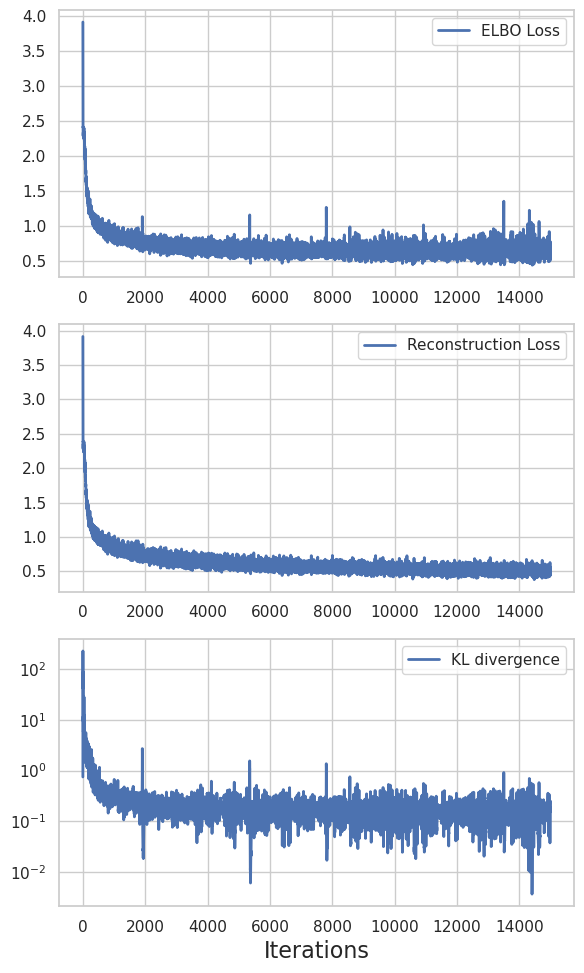

In [14]:
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(3,1,figsize=(6,9.9))

axes[0].plot(losses['LOSS_VAE'], label='ELBO Loss', linewidth=2)
axes[1].plot(losses['LOSS_RECONSTRUCTION'], label='Reconstruction Loss', linewidth=2)
axes[2].plot(losses['LOSS_KLDIVERGENCE'], label='KL divergence', linewidth=2)

#ax.set_ylabel('Loss', fontsize=16)
axes[2].set_xlabel('Iterations', fontsize=16)

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')

axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

In [15]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        sel = generator.evaluate(gen_data)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = normalize_SMILES(sf.decoder(sel))
        generated.append(smi)
    return generated

In [16]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [17]:
n_sampling = 30000

smi_after = SMILES_generate(my_generator, n_sampling, gen_data)

100%|██████████| 30000/30000 [42:09<00:00, 11.86it/s]


In [18]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_1_pretraining_ReBADD/zinc15_char/smi_after.csv
